### Build Spark session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/07 00:22:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load dataset

In [2]:
from sklearn.datasets import load_iris
import pandas as pd

In [5]:
iris = load_iris()
iris_data, iris_label = iris.data, iris.target
iris_columns = list(map(lambda col: col.replace('al ', 'al_').replace(' (cm)', ''), iris.feature_names))
iris_columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [6]:
iris_pdf = pd.DataFrame(iris_data, columns=iris_columns)
iris_pdf['label'] = iris_label
iris_sdf = spark.createDataFrame(iris_pdf)
iris_sdf.show()

+------------+-----------+------------+-----------+-----+
|sepal_length|sepal_width|petal_length|petal_width|label|
+------------+-----------+------------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|    0|
|         4.9|        3.0|         1.4|        0.2|    0|
|         4.7|        3.2|         1.3|        0.2|    0|
|         4.6|        3.1|         1.5|        0.2|    0|
|         5.0|        3.6|         1.4|        0.2|    0|
|         5.4|        3.9|         1.7|        0.4|    0|
|         4.6|        3.4|         1.4|        0.3|    0|
|         5.0|        3.4|         1.5|        0.2|    0|
|         4.4|        2.9|         1.4|        0.2|    0|
|         4.9|        3.1|         1.5|        0.1|    0|
|         5.4|        3.7|         1.5|        0.2|    0|
|         4.8|        3.4|         1.6|        0.2|    0|
|         4.8|        3.0|         1.4|        0.1|    0|
|         4.3|        3.0|         1.1|        0.1|    0|
|         5.8|

In [9]:
import pyspark.sql.functions as F

iris_sdf.printSchema()
iris_sdf.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in iris_columns]).show()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- label: long (nullable = true)



+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|           0|          0|           0|          0|
+------------+-----------+------------+-----------+



In [11]:
iris_sdf.describe().show()

23/06/07 00:34:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+
|summary|      sepal_length|       sepal_width|      petal_length|       petal_width|             label|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333334|3.0573333333333337|3.7580000000000005|1.1993333333333331|               1.0|
| stddev|0.8280661279778632|0.4358662849366982|1.7652982332594662|0.7622376689603466|0.8192319205190405|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



In [14]:
iris_sdf.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   50|
|    1|   50|
|    2|   50|
+-----+-----+



### Decision Tree

In [15]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols=iris_columns, outputCol='features')
vectorized_sdf = vector_assembler.transform(iris_sdf)
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2023)

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(maxDepth=4, minInstancesPerNode=5)
dt_model = dt_classifier.fit(train_sdf)
dt_predictions = dt_model.transform(test_sdf)

In [17]:
type(dt_model)

pyspark.ml.classification.DecisionTreeClassificationModel

In [18]:
dt_predictions.show()

+------------+-----------+------------+-----------+-----+-----------------+--------------+--------------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|label|         features| rawPrediction|         probability|prediction|
+------------+-----------+------------+-----------+-----+-----------------+--------------+--------------------+----------+
|         4.8|        3.4|         1.6|        0.2|    0|[4.8,3.4,1.6,0.2]|[44.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         5.4|        3.7|         1.5|        0.2|    0|[5.4,3.7,1.5,0.2]|[44.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         5.1|        3.5|         1.4|        0.3|    0|[5.1,3.5,1.4,0.3]|[44.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         5.1|        3.8|         1.5|        0.3|    0|[5.1,3.8,1.5,0.3]|[44.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         4.8|        3.1|         1.6|        0.2|    0|[4.8,3.1,1.6,0.2]|[44.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         5.0|  

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy_evaluator.evaluate(dt_predictions)

0.8235294117647058

In [19]:
dt_classifier.extractParamMap()

{Param(parent='DecisionTreeClassifier_599fa0e0caf4', name='seed', doc='random seed.'): -7911416588249794542,
 Param(parent='DecisionTreeClassifier_599fa0e0caf4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4,
 Param(parent='DecisionTreeClassifier_599fa0e0caf4', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='DecisionTreeClassifier_599fa0e0caf4', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 5,
 Param(parent='DecisionTreeClassifier_599fa0e0caf4', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='

In [20]:
dt_params = {k.name: v for k, v in dt_classifier.extractParamMap().items()}
dt_params

{'seed': -7911416588249794542,
 'maxDepth': 4,
 'maxBins': 32,
 'minInstancesPerNode': 5,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'impurity': 'gini',
 'leafCol': '',
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'featuresCol': 'features',
 'labelCol': 'label',
 'rawPredictionCol': 'rawPrediction',
 'probabilityCol': 'probability'}

In [23]:
dt_model.numFeatures, dt_model.numClasses, dt_model.getLabelCol(), dt_model.numNodes, dt_model.depth, dt_model.featureImportances

(4, 3, 'label', 5, 2, SparseVector(4, {2: 1.0}))

In [24]:
from pyspark.ml.linalg import DenseVector

print(type(dt_model.featureImportances))
dt_ft_importances = DenseVector(dt_model.featureImportances)
print(type(dt_ft_importances), dt_ft_importances)

<class 'pyspark.ml.linalg.SparseVector'>
<class 'pyspark.ml.linalg.DenseVector'> [0.0,0.0,1.0,0.0]


In [25]:
for name, value in zip(iris_sdf.columns, dt_ft_importances):
    print(f'name: {name}, value: {value}')

name: sepal_length, value: 0.0
name: sepal_width, value: 0.0
name: petal_length, value: 1.0
name: petal_width, value: 0.0


<Axes: >

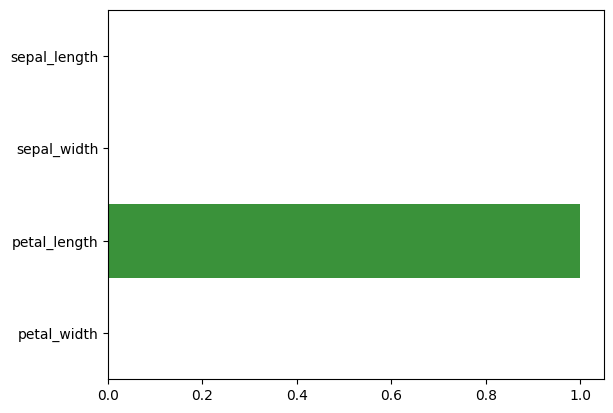

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=dt_ft_importances, y=iris_columns)

### Random Forest

In [30]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(maxDepth=4, numTrees=100)
rf_model = rf_classifier.fit(train_sdf)
rf_predictions = rf_model.transform(test_sdf)

In [34]:
accuracy_evaluator.evaluate(rf_predictions)

0.8823529411764706

In [31]:
rf_params = {k.name: v for k, v in rf_classifier.extractParamMap().items()}
rf_params

{'seed': -2052936014954402165,
 'maxDepth': 4,
 'maxBins': 32,
 'minInstancesPerNode': 1,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'impurity': 'gini',
 'numTrees': 100,
 'featureSubsetStrategy': 'auto',
 'subsamplingRate': 1.0,
 'leafCol': '',
 'minWeightFractionPerNode': 0.0,
 'bootstrap': True,
 'predictionCol': 'prediction',
 'featuresCol': 'features',
 'labelCol': 'label',
 'rawPredictionCol': 'rawPrediction',
 'probabilityCol': 'probability'}

<Axes: >

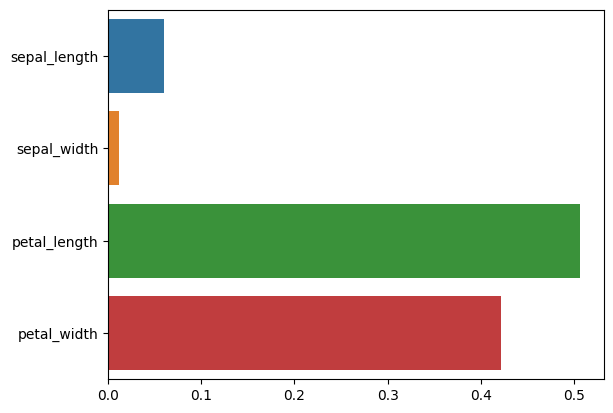

In [32]:
rf_ft_importances = DenseVector(rf_model.featureImportances)
sns.barplot(x=rf_ft_importances, y=iris_columns)

### Gradient Boost

In [35]:
from pyspark.ml.classification import GBTClassifier

# error: only supports binary classification
gbt_classifier = GBTClassifier(maxDepth=4, maxIter=30)
gbt_model = gbt_classifier.fit(train_sdf)
gbt_predictions = gbt_model.transform(test_sdf)

23/06/07 01:15:30 ERROR Executor: Exception in task 20.0 in stage 52.0 (TID 786)
java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.colle

Py4JJavaError: An error occurred while calling o479.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 20 in stage 52.0 failed 1 times, most recent failure: Lost task 20.0 in stage 52.0 (TID 786) (bac044c6c4c0 executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1196)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2357)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2358)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1198)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1191)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1196)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2357)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [36]:
[param.name for param in gbt_classifier.params]

['cacheNodeIds',
 'checkpointInterval',
 'featureSubsetStrategy',
 'featuresCol',
 'impurity',
 'labelCol',
 'leafCol',
 'lossType',
 'maxBins',
 'maxDepth',
 'maxIter',
 'maxMemoryInMB',
 'minInfoGain',
 'minInstancesPerNode',
 'minWeightFractionPerNode',
 'predictionCol',
 'probabilityCol',
 'rawPredictionCol',
 'seed',
 'stepSize',
 'subsamplingRate',
 'thresholds',
 'validationIndicatorCol',
 'validationTol',
 'weightCol']

### Random Forest, Gradient Boosting with breast cancer data

In [38]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
cancer_columns = cancer.feature_names
cancer_pdf = pd.DataFrame(cancer.data, columns=cancer_columns)
cancer_pdf['label'] = cancer.target
cancer_sdf = spark.createDataFrame(cancer_pdf)
cancer_sdf.count(), cancer_sdf.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|label|
+-----------+-

(569, None)

In [39]:
cancer_sdf.printSchema()
cancer_sdf.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in cancer_columns]).show()

root
 |-- mean radius: double (nullable = true)
 |-- mean texture: double (nullable = true)
 |-- mean perimeter: double (nullable = true)
 |-- mean area: double (nullable = true)
 |-- mean smoothness: double (nullable = true)
 |-- mean compactness: double (nullable = true)
 |-- mean concavity: double (nullable = true)
 |-- mean concave points: double (nullable = true)
 |-- mean symmetry: double (nullable = true)
 |-- mean fractal dimension: double (nullable = true)
 |-- radius error: double (nullable = true)
 |-- texture error: double (nullable = true)
 |-- perimeter error: double (nullable = true)
 |-- area error: double (nullable = true)
 |-- smoothness error: double (nullable = true)
 |-- compactness error: double (nullable = true)
 |-- concavity error: double (nullable = true)
 |-- concave points error: double (nullable = true)
 |-- symmetry error: double (nullable = true)
 |-- fractal dimension error: double (nullable = true)
 |-- worst radius: double (nullable = true)
 |-- worst 

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|
+-----------+------------+

In [41]:
cancer_sdf.describe().show()

+-------+------------------+-----------------+------------------+-----------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------------------+-------------------+------------------+------------------+-----------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------------------+------------------+-----------------+------------------+-----------------+--------------------+------------------+-------------------+--------------------+--------------------+-----------------------+------------------+
|summary|       mean radius|     mean texture|    mean perimeter|        mean area|     mean smoothness|    mean compactness|     mean concavity| mean concave points|       mean symmetry|mean fractal dimension|       radius error|     texture error|   perimeter error|       area error|    smoothness error|   compactness error|    concavity error|concave points err

In [53]:
cancer_sdf.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  212|
|    1|  357|
+-----+-----+



In [47]:
vector_assembler = VectorAssembler(inputCols=cancer_columns, outputCol='features')
vectorized_sdf = vector_assembler.transform(cancer_sdf)
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2021)

In [48]:
train_sdf.count(), test_sdf.count()

(458, 111)

In [51]:
rf_classifier = RandomForestClassifier(maxDepth=4, numTrees=100)
rf_model = rf_classifier.fit(train_sdf)
rf_predictions = rf_model.transform(test_sdf)
accuracy_evaluator.evaluate(rf_predictions)

0.9279279279279279

In [52]:
gbt_classifier = GBTClassifier(maxDepth=4, maxIter=30)
gbt_model = gbt_classifier.fit(train_sdf)
gbt_predictions = gbt_model.transform(test_sdf)
accuracy_evaluator.evaluate(gbt_predictions)

23/06/07 01:31:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.9369369369369369

### Evaluation

In [54]:
evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
evaluator_f1_score = MulticlassClassificationEvaluator(metricName='f1')

In [55]:
print('evaluator_precision:', evaluator_precision.evaluate(rf_predictions))
print('evaluator_recall:', evaluator_recall.evaluate(rf_predictions))
print('evaluator_f1_score:', evaluator_f1_score.evaluate(rf_predictions))

evaluator_precision: 0.9297728579643474


evaluator_recall: 0.927927927927928


evaluator_f1_score: 0.927619522089568


In [56]:
rf_predictions_pdf = rf_predictions.select('label', 'prediction').toPandas()
rf_predictions_pdf

,label,prediction
0,0,0.0
1,1,1.0
2,0,0.0
3,1,1.0
4,0,0.0
...,...,...
106,1,1.0
107,1,1.0
108,0,1.0
109,0,0.0


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

sk_precision = precision_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_precision_weighted = precision_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')
sk_recall = recall_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_recall_weighted = recall_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')
sk_f1_score = f1_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'])
sk_f1_score_weighted = f1_score(rf_predictions_pdf['label'], rf_predictions_pdf['prediction'], average='weighted')

# spark_evaluator_precision: 0.9297728579643474
# spark_evaluator_recall: 0.927927927927928
# spark_evaluator_f1_score: 0.927619522089568

print('sk_precision:', sk_precision)
print('sk_precision_weighted:', sk_precision_weighted)
print('sk_recall:', sk_recall)
print('sk_recall_weighted:', sk_recall_weighted)
print('sk_f1_score:', sk_f1_score)
print('sk_f1_score_weighted:', sk_f1_score_weighted)


sk_precision: 0.90625
sk_precision_weighted: 0.9297728579643474
sk_recall: 0.9666666666666667
sk_recall_weighted: 0.9279279279279279
sk_f1_score: 0.9354838709677419
sk_f1_score_weighted: 0.9276195220895681


In [60]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evalutor_roc = BinaryClassificationEvaluator(metricName='areaUnderROC')
print('evalutor_roc:', evalutor_roc.evaluate(rf_predictions))

evalutor_roc: 0.9859477124183007


In [61]:
rf_predictions.printSchema()

root
 |-- mean radius: double (nullable = true)
 |-- mean texture: double (nullable = true)
 |-- mean perimeter: double (nullable = true)
 |-- mean area: double (nullable = true)
 |-- mean smoothness: double (nullable = true)
 |-- mean compactness: double (nullable = true)
 |-- mean concavity: double (nullable = true)
 |-- mean concave points: double (nullable = true)
 |-- mean symmetry: double (nullable = true)
 |-- mean fractal dimension: double (nullable = true)
 |-- radius error: double (nullable = true)
 |-- texture error: double (nullable = true)
 |-- perimeter error: double (nullable = true)
 |-- area error: double (nullable = true)
 |-- smoothness error: double (nullable = true)
 |-- compactness error: double (nullable = true)
 |-- concavity error: double (nullable = true)
 |-- concave points error: double (nullable = true)
 |-- symmetry error: double (nullable = true)
 |-- fractal dimension error: double (nullable = true)
 |-- worst radius: double (nullable = true)
 |-- worst 

In [67]:
rf_predictions.select('probability').show(truncate=False)

+-----------------------------------------+
|probability                              |
+-----------------------------------------+
|[0.8709197228224355,0.12908027717756446] |
|[0.04543482104845406,0.9545651789515459] |
|[0.9810799234283324,0.01892007657166763] |
|[0.022308394226249032,0.977691605773751] |
|[0.5140626174190306,0.48593738258096936] |
|[0.9947351744496113,0.005264825550388727]|
|[0.9947351744496113,0.005264825550388727]|
|[0.9947351744496113,0.005264825550388727]|
|[0.9948617567280923,0.005138243271907713]|
|[0.012584855545093735,0.9874151444549062]|
|[0.9064821469849753,0.09351785301502465] |
|[0.013522355545093734,0.9864776444549063]|
|[0.012347304732085604,0.9876526952679144]|
|[0.22002508995334616,0.7799749100466539] |
|[0.2093389836174959,0.7906610163825042]  |
|[0.994060884773462,0.00593911522653796]  |
|[0.9949732696877065,0.005026730312293488]|
|[0.011974097687360071,0.9880259023126399]|
|[0.01207471452332826,0.9879252854766718] |
|[0.6051097412751454,0.394890258

In [68]:
from pyspark.ml.functions import vector_to_array
rf_predictions_pdf = rf_predictions.select('label',
                                            vector_to_array('probability')[0].alias('probability_0'),
                                            vector_to_array('probability')[1].alias('probability_1')
                                            ).toPandas()
rf_predictions_pdf

,label,probability_0,probability_1
0,0,0.870920,0.129080
1,1,0.045435,0.954565
2,0,0.981080,0.018920
3,1,0.022308,0.977692
4,0,0.514063,0.485937
...,...,...,...
106,1,0.012946,0.987054
107,1,0.015434,0.984566
108,0,0.377887,0.622113
109,0,0.958018,0.041982


In [70]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])
print('roc_auc:', roc_auc)

roc_auc: 0.9859477124183007


In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(predictions_sdf, label_column='label'):
    predictions_pdf = predictions_sdf.select(
                                                label_column,
                                                'prediction',
                                                vector_to_array('probability')[0].alias('probability_0'),
                                                vector_to_array('probability')[1].alias('probability_1')
                    ).toPandas()
    label = predictions_pdf[label_column].values
    prediction = predictions_pdf['prediction'].values
    probability_1 = predictions_pdf['probability_1'].values
    cm = confusion_matrix(label, prediction)
    accuracy = accuracy_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)
    f1 = f1_score(label, prediction)
    roc_auc = roc_auc_score(label, probability_1)
    print('confusion matrix:\n', cm)
    print(f'accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}, roc_auc: {roc_auc}')

In [73]:
get_clf_eval(rf_predictions)

confusion matrix:
 [[45  6]
 [ 2 58]]
accuracy: 0.9279279279279279, precision: 0.90625, recall: 0.9666666666666667, f1: 0.9354838709677419, roc_auc: 0.9859477124183007


In [77]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, threshold = roc_curve(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])
print(f'threshold shape: {threshold.shape}')
thr_idx = np.arange(0, threshold.shape[0], 2)
print(f'threshold index: {thr_idx}')
print(f'thresholds of 10 samples: {np.round(threshold[thr_idx], 2)}')
print(f'fpr of 10 samples: {np.round(fpr[thr_idx], 3)}')
print(f'tpr of 10 samples: {np.round(tpr[thr_idx], 3)}')

threshold shape: (29,)
threshold index: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28]
thresholds of 10 samples: [1.99 0.99 0.99 0.99 0.98 0.94 0.78 0.7  0.62 0.51 0.39 0.01 0.01 0.01
 0.01]
fpr of 10 samples: [0.    0.    0.    0.    0.    0.02  0.059 0.078 0.098 0.118 0.235 0.686
 0.765 0.941 1.   ]
tpr of 10 samples: [0.    0.1   0.25  0.35  0.65  0.8   0.883 0.917 0.933 0.967 0.983 1.
 1.    1.    1.   ]


In [75]:
def roc_curve_plot(y_test, pred_proba_c1):
    fpr, tpr, _ = roc_curve(y_test, pred_proba_c1)
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

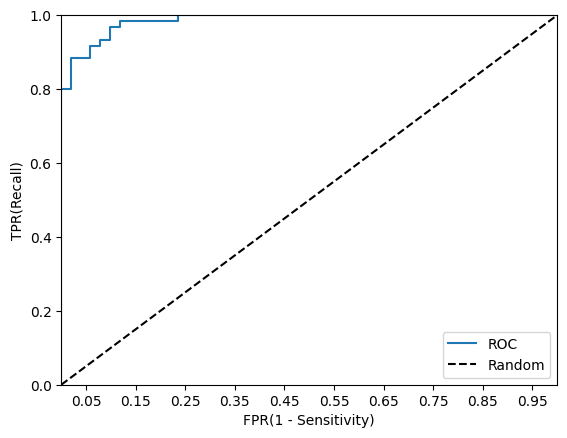

In [76]:
roc_curve_plot(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])

In [81]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])
print('thresholds.shape:', thresholds.shape)
print('precisions.shape:', precisions.shape)
print('recalls.shape:', recalls.shape)
print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])
thr_idx = np.arange(0, thresholds.shape[0], 9)
print(f'threshold index: {thr_idx}')
print(f'thresholds of 10 samples: {np.round(thresholds[thr_idx], 2)}')
print(f'precisions of 10 samples: {np.round(precisions[thr_idx], 3)}')
print(f'recalls of 10 samples: {np.round(recalls[thr_idx], 3)}')


thresholds.shape: (90,)
precisions.shape: (91,)
recalls.shape: (91,)
thresholds 5 sample: [0.00502673 0.00513824 0.00526483 0.00547759 0.00550989]
precisions 5 sample: [0.54054054 0.55045872 0.55555556 0.59405941 0.60606061]
recalls 5 sample: [1. 1. 1. 1. 1.]
threshold index: [ 0  9 18 27 36 45 54 63 72 81]
thresholds of 10 samples: [0.01 0.02 0.03 0.19 0.5  0.78 0.95 0.98 0.98 0.99]
precisions of 10 samples: [0.541 0.652 0.723 0.811 0.908 0.946 1.    1.    1.    1.   ]
recalls of 10 samples: [1.    1.    1.    1.    0.983 0.883 0.783 0.583 0.433 0.267]


In [82]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

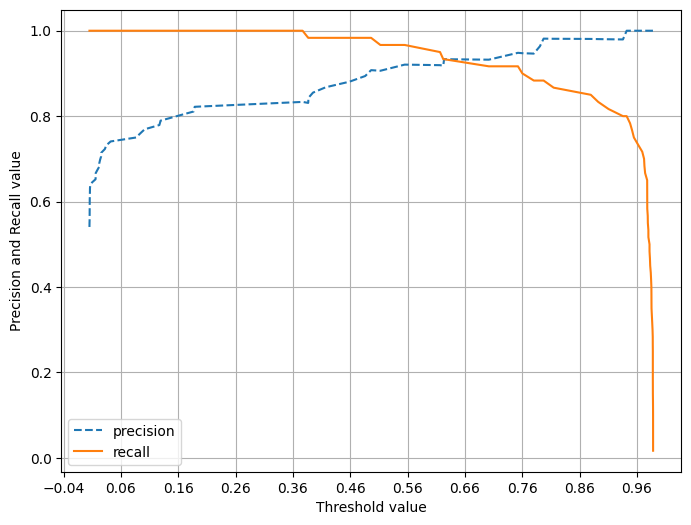

In [83]:
precision_recall_curve_plot(rf_predictions_pdf['label'], rf_predictions_pdf['probability_1'])